# PLEASE SEE DETAILS in REPORT.pdf
# Also, the main GRABCUT class I have implemented is in grabcut_helper.py which has been imported in this notebook.
### User refinement examples are present at the bottom

In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import numpy as np
import cv2
#################
import os
import sys
from time import time
import matplotlib.pyplot as plt
import json
import glob
import math
from sklearn import mixture
from collections import Counter
from numpy import linalg as LA
from grabcut_helper import *
import cProfile, pstats, io
import imageio
from time import time

In [15]:
from matplotlib.colors import from_levels_and_colors
use_cmap, use_norm = from_levels_and_colors([0,1,2,3,4,5],['black','green','blue','red','yellow'])

In [16]:
class EventHandler:
    """
    Class for handling user input during segmentation iterations 
    """
    
    def __init__(self, flags, img, _mask, colors):
        
        self.FLAGS = flags
        self.ix = -1
        self.iy = -1
        self.img = img
        self.img2 = self.img.copy()
        self._mask = _mask
        self.COLORS = colors

    @property
    def image(self):
        return self.img
    
    @image.setter
    def image(self, img):
        self.img = img
        
    @property
    def mask(self):
        return self._mask
    
    @mask.setter
    def mask(self, _mask):
        self._mask = _mask
    
    @property
    def flags(self):
        return self.FLAGS 
    
    @flags.setter
    def flags(self, flags):
        self.FLAGS = flags
    
    def handler(self, event, x, y, flags, param):

        # Draw the rectangle first
        if event == cv2.EVENT_RBUTTONDOWN:
            self.FLAGS['DRAW_RECT'] = True
            self.ix, self.iy = x,y

        elif event == cv2.EVENT_MOUSEMOVE:
            if self.FLAGS['DRAW_RECT'] == True:
                self.img = self.img2.copy()
                cv2.rectangle(self.img, (self.ix, self.iy), (x, y), self.COLORS['BLUE'], 2)
                self.FLAGS['RECT'] = (min(self.ix, x), min(self.iy, y), abs(self.ix - x), abs(self.iy - y))
                self.FLAGS['rect_or_mask'] = 0

        elif event == cv2.EVENT_RBUTTONUP:
            self.FLAGS['DRAW_RECT'] = False
            self.FLAGS['rect_over'] = True
            cv2.rectangle(self.img, (self.ix, self.iy), (x, y), self.COLORS['BLUE'], 2)
            self.FLAGS['RECT'] = (min(self.ix, x), min(self.iy, y), abs(self.ix - x), abs(self.iy - y))
            self.FLAGS['rect_or_mask'] = 0

        
        # Draw strokes for refinement 

        if event == cv2.EVENT_LBUTTONDOWN:
            if self.FLAGS['rect_over'] == False:
                print('Draw the rectangle first.')
            else:
                self.FLAGS['DRAW_STROKE'] = True
                # cv2.circle(image, center_coordinates, radius, color, thickness)
                # Color is BLACK FOR background
                # Color is WHITE for foreground
                cv2.circle(self.img, (x,y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x,y), 3, self.FLAGS['value']['val'], -1)

        elif event == cv2.EVENT_MOUSEMOVE:
            if self.FLAGS['DRAW_STROKE'] == True:
                cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x, y), 3, self.FLAGS['value']['val'], -1)

        elif event == cv2.EVENT_LBUTTONUP:
            if self.FLAGS['DRAW_STROKE'] == True:
                self.FLAGS['DRAW_STROKE'] = False
                cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x, y), 3, self.FLAGS['value']['val'], -1)

In [29]:
def run(filename: str, DEFAULT_ITRS=1,connectivity=8, input_num_gmms=5,input_gamma=50 ):
    """
    Main loop that implements GrabCut. 
    
    Input
    -----
    filename (str) : Path to image
    """
    
    # storing the ascii values for the colors used in the user annotation
    COLORS = {
    'BLACK' : [0,0,0],
    'RED'   : [0, 0, 255],
    'GREEN' : [0, 255, 0],
    'BLUE'  : [255, 0, 0],
    'WHITE' : [255,255,255]
    }
    
    DRAW_BG = {'color' : COLORS['BLACK'], 'val' : 3}
    DRAW_FG = {'color' : COLORS['WHITE'], 'val' : 4}
    
    # various flags in the GUI
    FLAGS = {
        'RECT' : (0, 0, 1, 1),
        'DRAW_STROKE': False,         # flag for drawing strokes
        'DRAW_RECT' : False,          # flag for drawing rectangle
        'rect_over' : False,          # flag to check if rectangle is  drawn
        'rect_or_mask' : -1,          # flag for selecting rectangle or stroke mode
        'value' : DRAW_FG,            # drawing strokes initialized to mark foreground
    }

    # read the image
    img = cv2.imread(filename)
    #img=img[300:320, 300:320]
    
    # store a copy
    img2 = img.copy()     
    
    # binary matrix denoting foreground and background
    mask = np.zeros(img.shape[:2], dtype = np.uint8) # mask is a binary array with : 0 - background pixels
                                                     #                               1 - foreground pixels 
    #print("Shape of the image is ", img.shape)
    
    output = np.zeros(img.shape, np.uint8)           # output image to be shown

    # Input and segmentation windows
    cv2.namedWindow('Input Image')
    cv2.namedWindow('Segmented image')
    
    EventObj = EventHandler(FLAGS, img, mask, COLORS)
    cv2.setMouseCallback('Input Image', EventObj.handler)
    cv2.moveWindow('Input Image', img.shape[1] + 10, 90)
    
    grabcut_obj=None
    rect_done=False
    
    #print("Initial contents of EventHandler mask is ", Counter((EventObj._mask).flatten()))

    
    while(1):
        
        # stores the image, the mask so far due to GrabCut and the flags of the user operations
        img = EventObj.image
        mask = EventObj.mask
        FLAGS = EventObj.flags
        cv2.imshow('Segmented image', output)
        cv2.imshow('Input Image', img)
        k = cv2.waitKey(1)

        # key bindings
        if k == 27:
            # esc to exit
            break
        
        elif k == ord('0'): 
            # Strokes for background
            FLAGS['value'] = DRAW_BG
        
        elif k == ord('1'):
            # FG drawing
            FLAGS['value'] = DRAW_FG
        
        elif k == ord('r'):
            # reset everything
            FLAGS['RECT'] = (0, 0, 1, 1)
            FLAGS['DRAW_STROKE'] = False
            FLAGS['DRAW_RECT'] = False
            FLAGS['rect_or_mask'] = -1
            FLAGS['rect_over'] = False
            FLAGS['value'] = DRAW_FG
            img = img2.copy()
            mask = np.zeros(img.shape[:2], dtype = np.uint8) 

            EventObj.image = img
            EventObj.mask = mask
            output = np.zeros(img.shape, np.uint8)
        
        elif k == 13: 
            #print("Flags are ", FLAGS)

            # Press carriage return to initiate segmentation
            
            #-------------------------------------------------#
            # Implement GrabCut here.                         #  
            # Function should return a mask which can be used #
            # to segment the original image as shown on L90   # 
            #-------------------------------------------------#
            
            # initially, mask is simply 0 for all
            #print("mask obtained")
            
            # take care that lb_h IS NOT ALWAYS lower than ub_h
            # hence, take care of this technicality+++
            #mask=np.random.randint(2,size=img.shape[:2])
            EventObj.flags = FLAGS
            if FLAGS['rect_over']==True and (not rect_done):
                print("A rectangle has been drawn")
                #mask=fetch_grabcut_mask(img,FLAGS['RECT'] )
                
                ####################################
                '''with open("saved_rects.json",'r') as fd:
                    df=json.load(fd)
                    if filename not in df:
                        df[filename]=[]
                        print("have to write")
                        df[filename]=FLAGS['RECT']
                    FLAGS['RECT']=df[filename]
                with open("saved_rects.json",'w') as fd:
                    json.dump(df, fd)'''
                ###########################
                rect_done=True
                #return None
                grabcut_obj=grabcut_class(img2, FLAGS['RECT'], fetch_gt_path(filename), img, 
                                                  ITERATIONS=DEFAULT_ITRS,
                                                 connectivity=connectivity, 
                                                  NUM_GMMS_PER_LABEL=input_num_gmms,
                                                     gamma_val=input_gamma)

                perform_pipeline(grabcut_obj, DEFAULT_ITRS)
                
            elif rect_done:
                #print("other types of tinkering")
                #plt.imshow(EventObj.mask,cmap=use_cmap, norm=use_norm,interpolation=None)
                #print("Current contents of EventHandler mask is ", Counter((EventObj._mask).flatten()))
                #plt.show()
                grabcut_obj.refine_segmentation(EventObj.mask)
                perform_pipeline(grabcut_obj, 1, False)
                pass
            if grabcut_obj!=None:
                mask=np.copy(grabcut_obj.curr_matte)
                
            # if true, then put 255 else put 0, mask =1 foreground
            mask2 = np.where((mask == 1), 255, 0).astype('uint8')
            output = cv2.bitwise_and(img2, img2, mask = mask2)
            #save_img_func(fetch_img_cat(filename), output)
            #return grabcut_obj

    return grabcut_obj

In [18]:
def fetch_img_cat(main_path):
    a=main_path.split("/")[-1]
    a=a.split(".")[0]
    return a

In [30]:
def perform_pipeline(ans, NUM_ITRS, make_graph=True):
    if make_graph:
        #start_time = time()
        ans.init_graph()
        #end_time = time()
        #seconds_elapsed = end_time - start_time
        #print("Seconds taken to construct graph is :",seconds_elapsed)
        print("Graph constructed")
    #########################
    for i in range(NUM_ITRS):
        ans.run_an_iteration()
        #print("Distribution is :",Counter(ans.curr_matte.flatten()))
        img_new=fetch_suspected_img(ans.curr_img , ans.curr_matte)
        plt.imshow(np.flip(img_new, axis=-1))
        plt.show()
        #print("---------")
    if make_graph:
        print("Initial pipeline over")

### For all plots, first the result of the iterations without any user intervention is shown.
### Then, if there is any user refinement, then the user refinement heatmap is shown and the result of the iteration immediately succeeding the refinement is shown adjacent to the refinement heatmap

# Experiments with the parameters

## Number of iterations

In [8]:
filename = '../images/scissors.jpg'               # Path to image file
ans=run(filename,DEFAULT_ITRS=7,connectivity=8,input_num_gmms=5, input_gamma=50)
cv2.destroyAllWindows()

In [9]:
ans

In [10]:
print(f"Total pipeline took {ans.time_track} secs for {len(ans.score_acc)} itrs (including costly overhead for storing state history for each iteration to make plots, user intervention etc)")
plot_all_details(ans)

AttributeError: 'NoneType' object has no attribute 'time_track'

## Effect of gamma (the extent of penalty for assigning different labels to neighboring edges)

A rectangle has been drawn
Size of the image is [h:600 ,w:450]
Bounding box coordinates:  {'w_min': 114, 'w_max': 346, 'h_min': 39, 'h_max': 539}
Graph constructed
Starting iteration: 0
Energy val:  3661293.084726258
Accuracy is  0.8783444444444445 | Jaccard is  0.5790627042405136
--------------------------


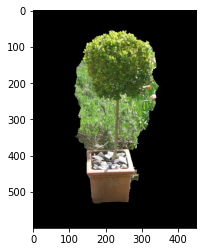

Starting iteration: 1
Energy val:  3629770.506144611
Accuracy is  0.9103925925925926 | Jaccard is  0.6455662823574222
--------------------------


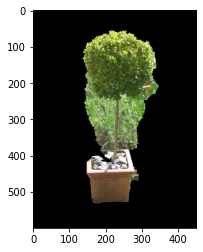

Starting iteration: 2
Energy val:  3619867.4284970285
Accuracy is  0.9601185185185185 | Jaccard is  0.774061562349189
--------------------------


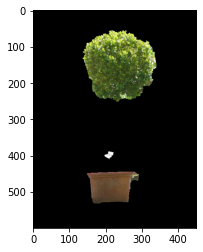

Starting iteration: 3
Energy val:  3602045.000004009
Accuracy is  0.9608333333333333 | Jaccard is  0.7752916427615223
--------------------------


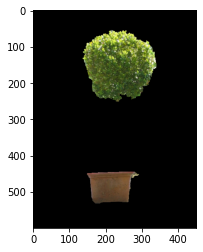

Starting iteration: 4
Energy val:  3597422.292660839
Accuracy is  0.9608222222222222 | Jaccard is  0.7752469988314034
--------------------------


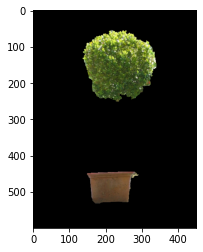

Initial pipeline over


In [32]:
filename = '../images/bush.jpg'               # Path to image file
ans=run(filename,DEFAULT_ITRS=5,connectivity=8,input_num_gmms=5, input_gamma=100)
cv2.destroyAllWindows()

Total pipeline took 85.88536071777344 secs for 5 itrs (including costly overhead for storing state history for each iteration to make plots, user intervention etc)


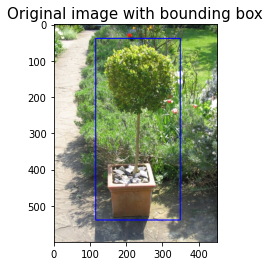

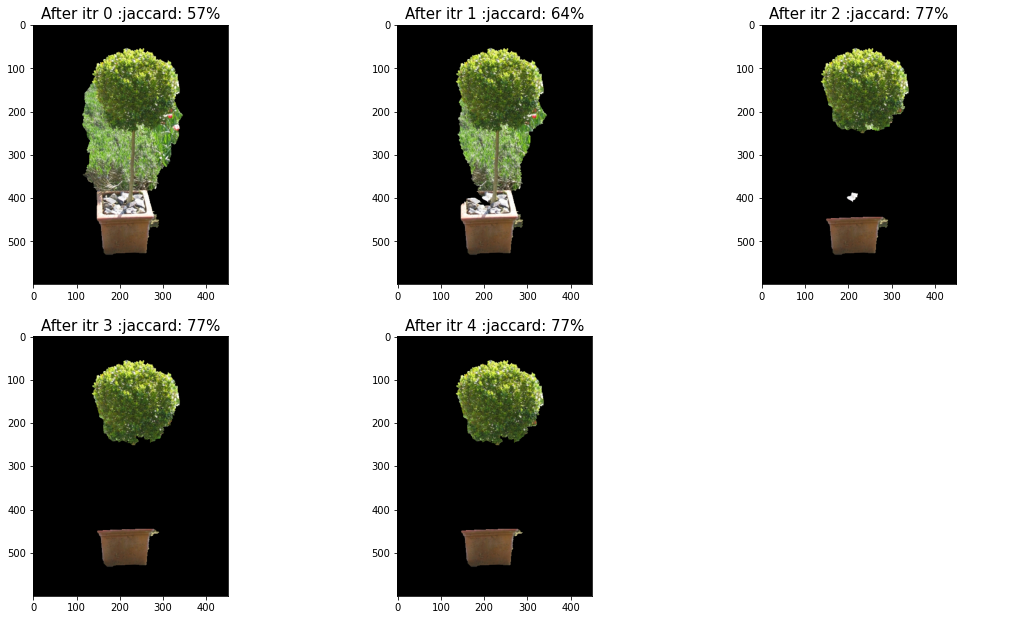

Accuracy:  [0.8783, 0.9104, 0.9601, 0.9608, 0.9608]
Jaccard:  [0.5791, 0.6456, 0.7741, 0.7753, 0.7752]
Dice score is:  [0.7334, 0.7846, 0.8726, 0.8734, 0.8734]


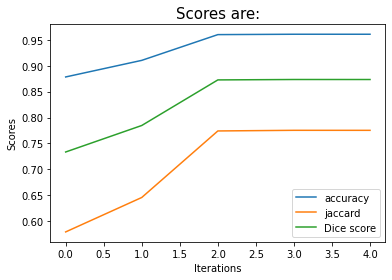

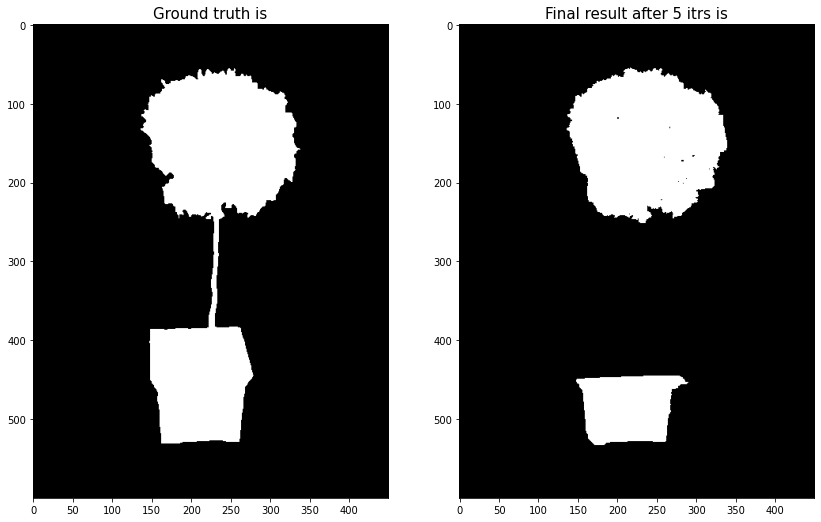

In [33]:
print(f"Total pipeline took {ans.time_track} secs for {len(ans.score_acc)} itrs (including costly overhead for storing state history for each iteration to make plots, user intervention etc)")
plot_all_details(ans)

A rectangle has been drawn
Size of the image is [h:600 ,w:450]
Bounding box coordinates:  {'w_min': 128, 'w_max': 334, 'h_min': 53, 'h_max': 541}
Graph constructed
Starting iteration: 0
Energy val:  3699792.0525257345
Accuracy is  0.9288814814814815 | Jaccard is  0.5904447051295724
--------------------------


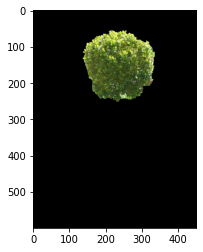

Starting iteration: 1
Energy val:  3634270.905677231
Accuracy is  0.9298222222222222 | Jaccard is  0.5928226066401633
--------------------------


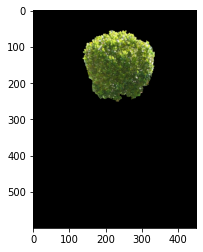

Starting iteration: 2
Energy val:  3633985.7741963463
Accuracy is  0.9298222222222222 | Jaccard is  0.5928226066401633
--------------------------


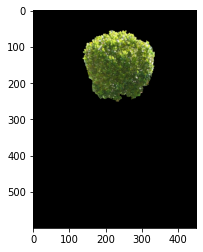

Starting iteration: 3
Energy val:  3633985.7741963463
Accuracy is  0.9298222222222222 | Jaccard is  0.5928226066401633
--------------------------


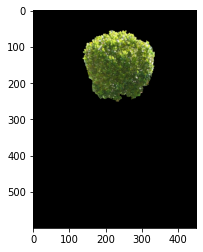

Starting iteration: 4
Energy val:  3633985.7741963463
Accuracy is  0.9298222222222222 | Jaccard is  0.5928226066401633
--------------------------


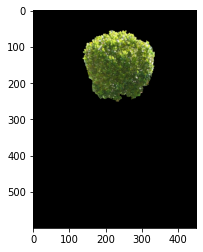

Initial pipeline over


In [36]:
filename = '../images/bush.jpg'               # Path to image file
ans=run(filename,DEFAULT_ITRS=5,connectivity=8,input_num_gmms=5, input_gamma=200)
cv2.destroyAllWindows()

Total pipeline took 83.26523876190186 secs for 5 itrs (including costly overhead for storing state history for each iteration to make plots, user intervention etc)


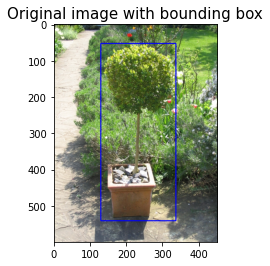

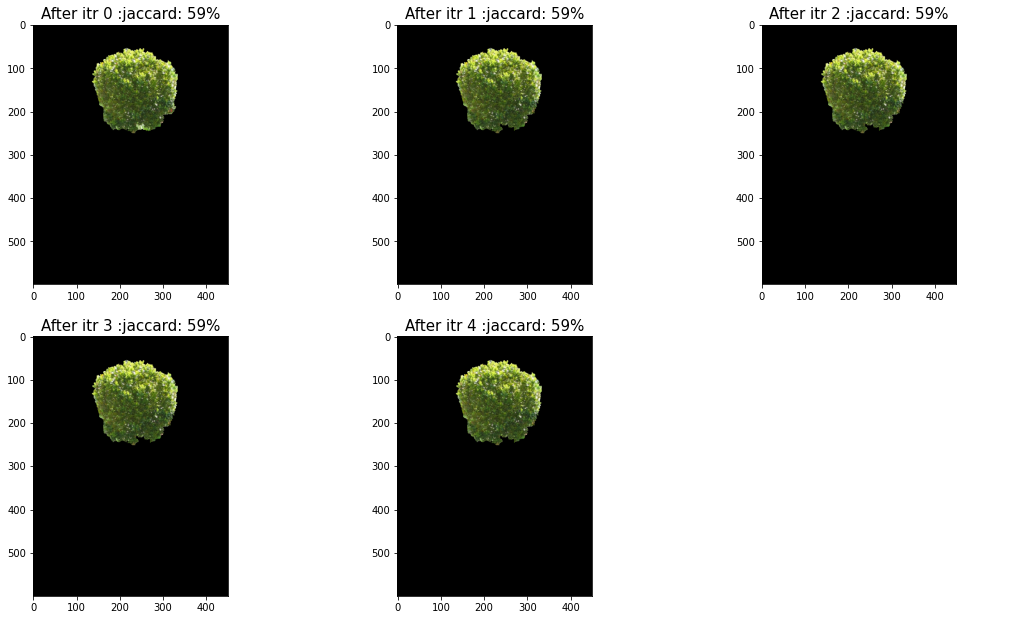

Accuracy:  [0.9289, 0.9298, 0.9298, 0.9298, 0.9298]
Jaccard:  [0.5904, 0.5928, 0.5928, 0.5928, 0.5928]
Dice score is:  [0.7425, 0.7444, 0.7444, 0.7444, 0.7444]


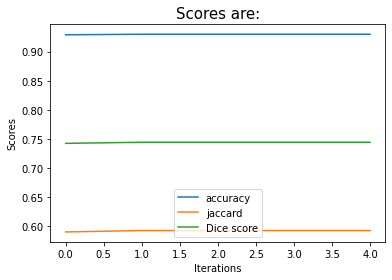

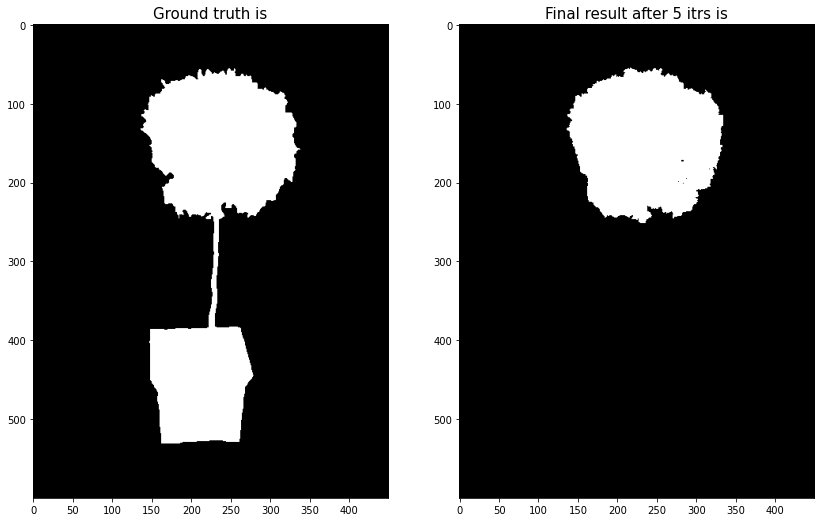

In [37]:
print(f"Total pipeline took {ans.time_track} secs for {len(ans.score_acc)} itrs (including costly overhead for storing state history for each iteration to make plots, user intervention etc)")
plot_all_details(ans)

In [79]:
cv2.destroyAllWindows()

A rectangle has been drawn
Size of the image is [h:480 ,w:640]
Bounding box coordinates:  {'w_min': 29, 'w_max': 606, 'h_min': 32, 'h_max': 427}
Graph constructed
Starting iteration: 0
Energy val:  3399356.2248624186
Accuracy is  0.7179622395833334 | Jaccard is  0.47380311799680547
--------------------------


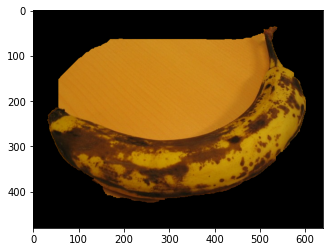

Starting iteration: 1
Energy val:  3278943.6787236044
Accuracy is  0.7435026041666667 | Jaccard is  0.4971313332439867
--------------------------


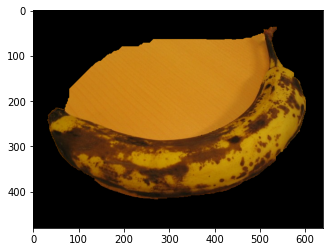

Starting iteration: 2
Energy val:  3252016.1839344674
Accuracy is  0.9942936197916666 | Jaccard is  0.9779352532474072
--------------------------


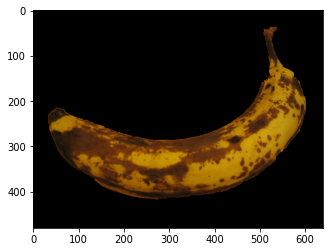

Initial pipeline over


KeyboardInterrupt: 

In [80]:
filename = '../images/banana1.jpg'               # Path to image file
ans=run(filename,DEFAULT_ITRS=3,connectivity=8,input_num_gmms=5, input_gamma=200)
cv2.destroyAllWindows()

In [53]:
cv2.destroyAllWindows()

## Number of Components in the Gaussian Mixture Foreground and Background Models


A rectangle has been drawn
Size of the image is [h:480 ,w:640]
Bounding box coordinates:  {'w_min': 84, 'w_max': 580, 'h_min': 28, 'h_max': 441}
Graph constructed
Starting iteration: 0
Energy val:  3519908.012250766
Accuracy is  0.965478515625 | Jaccard is  0.8981307154384077
--------------------------


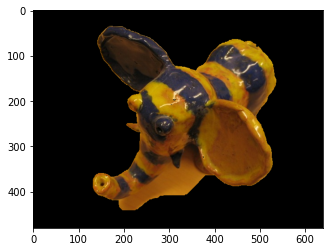

Starting iteration: 1
Energy val:  3361214.0874065016
Accuracy is  0.9681868489583333 | Jaccard is  0.9053462469733656
--------------------------


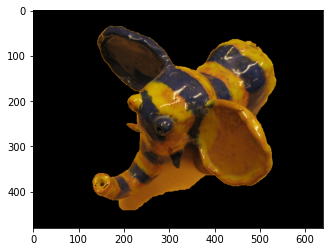

Starting iteration: 2
Energy val:  3360954.468366148
Accuracy is  0.96951171875 | Jaccard is  0.908924716544468
--------------------------


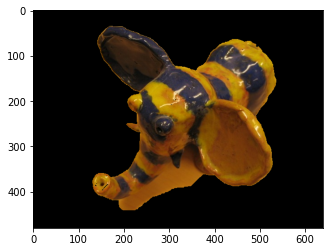

Starting iteration: 3
Energy val:  3360878.2155853165
Accuracy is  0.970166015625 | Jaccard is  0.9107038466035309
--------------------------


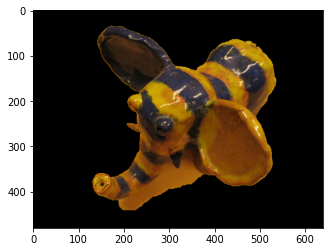

Initial pipeline over


In [48]:
filename = '../images/ceramic.jpg'               # Path to image file
ans=run(filename,DEFAULT_ITRS=4,connectivity=8,input_num_gmms=2, input_gamma=50)
cv2.destroyAllWindows()

Total pipeline took 40.37089228630066 secs for 4 itrs (including costly overhead for storing state history for each iteration to make plots, user intervention etc)


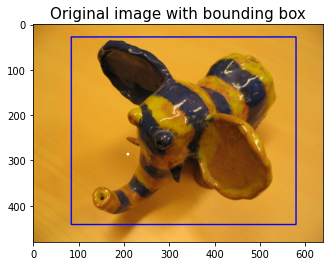

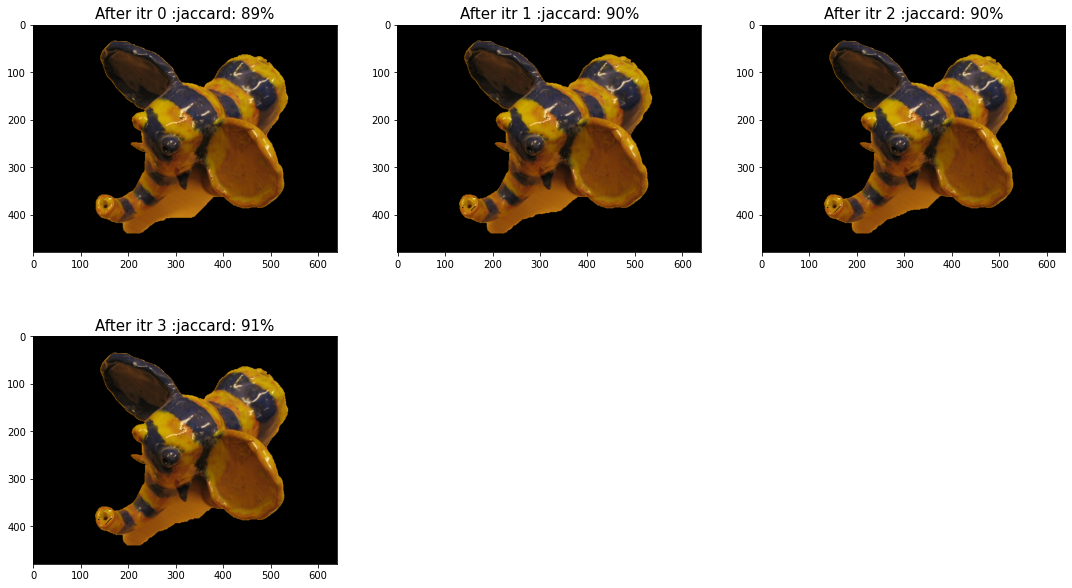

Accuracy:  [0.9655, 0.9682, 0.9695, 0.9702]
Jaccard:  [0.8981, 0.9053, 0.9089, 0.9107]
Dice score is:  [0.9463, 0.9503, 0.9523, 0.9533]


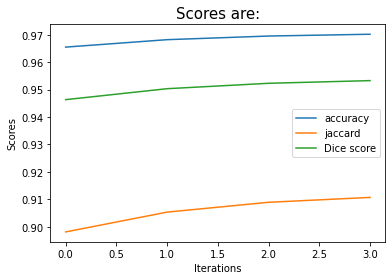

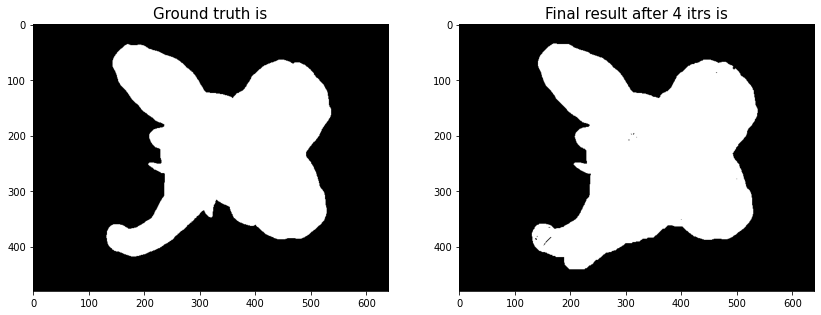

In [49]:
print(f"Total pipeline took {ans.time_track} secs for {len(ans.score_acc)} itrs (including costly overhead for storing state history for each iteration to make plots, user intervention etc)")
plot_all_details(ans)

In [55]:
#cv2.destroyAllWindows()

A rectangle has been drawn
Size of the image is [h:480 ,w:640]
Bounding box coordinates:  {'w_min': 91, 'w_max': 559, 'h_min': 26, 'h_max': 439}
Graph constructed
Starting iteration: 0
Energy val:  3296412.9416388595
Accuracy is  0.846298828125 | Jaccard is  0.664535243088859
--------------------------


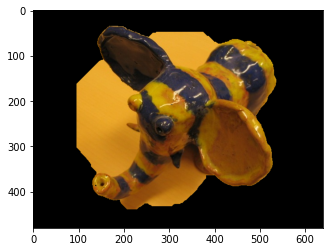

Starting iteration: 1
Energy val:  3220408.264549851
Accuracy is  0.8846028645833334 | Jaccard is  0.7250851111679811
--------------------------


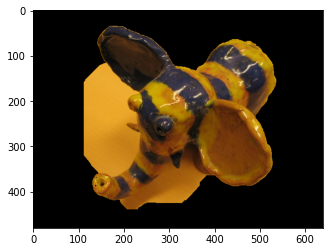

Starting iteration: 2
Energy val:  3206086.1380956606
Accuracy is  0.9116764322916666 | Jaccard is  0.7750426981942394
--------------------------


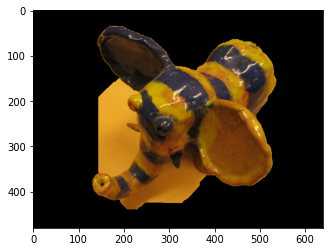

Starting iteration: 3
Energy val:  3191831.858295347
Accuracy is  0.941220703125 | Jaccard is  0.8381278518345868
--------------------------


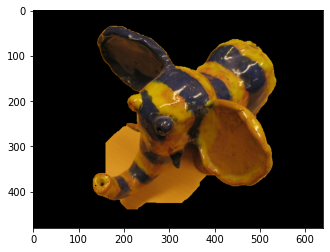

Starting iteration: 4
Energy val:  3178901.162945149
Accuracy is  0.9457779947916667 | Jaccard is  0.84875422220608
--------------------------


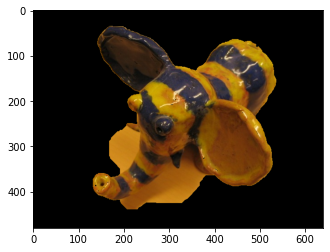

Starting iteration: 5
Energy val:  3183475.259729747
Accuracy is  0.9622591145833334 | Jaccard is  0.8896387606491838
--------------------------


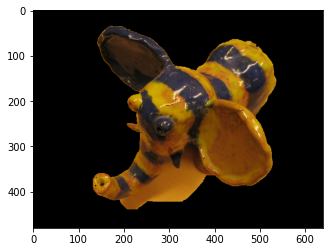

Starting iteration: 6
Energy val:  3168597.991858683
Accuracy is  0.9688606770833333 | Jaccard is  0.9071550586225638
--------------------------


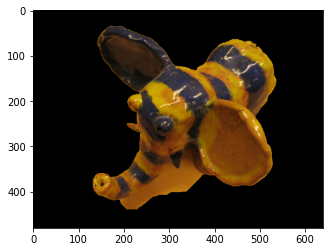

Initial pipeline over


In [56]:
filename = '../images/ceramic.jpg'               # Path to image file
ans=run(filename,DEFAULT_ITRS=7,connectivity=8,input_num_gmms=10, input_gamma=50)
cv2.destroyAllWindows()

Total pipeline took 191.27507066726685 secs for 7 itrs (including costly overhead for storing state history for each iteration to make plots, user intervention etc)


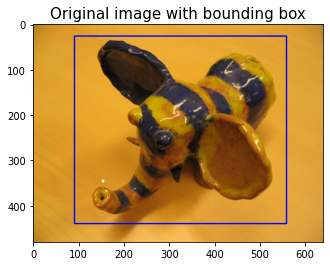

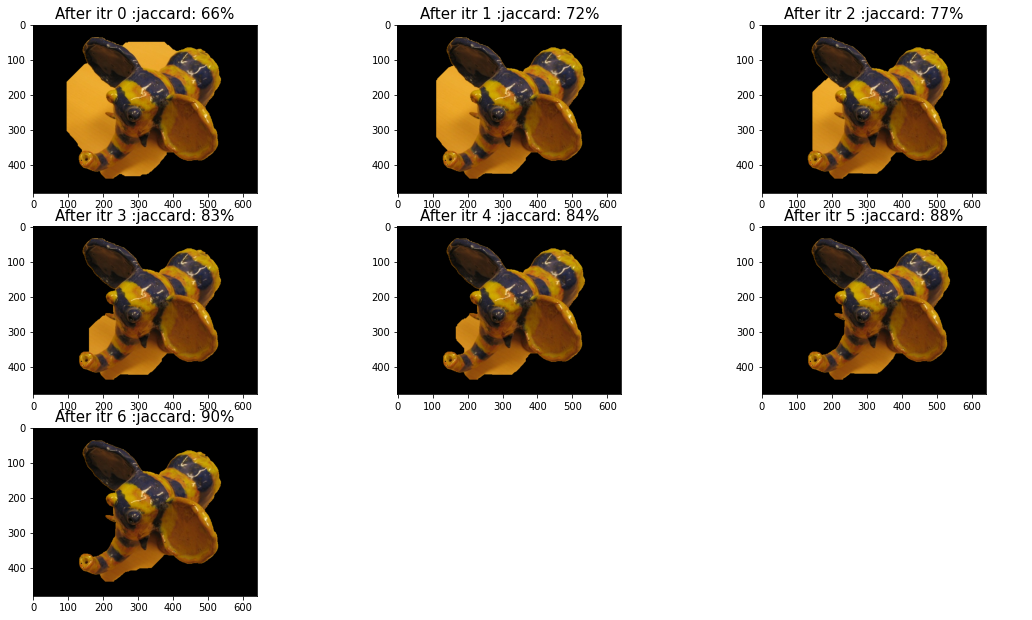

Accuracy:  [0.8463, 0.8846, 0.9117, 0.9412, 0.9458, 0.9623, 0.9689]
Jaccard:  [0.6645, 0.7251, 0.775, 0.8381, 0.8488, 0.8896, 0.9072]
Dice score is:  [0.7985, 0.8406, 0.8733, 0.9119, 0.9182, 0.9416, 0.9513]


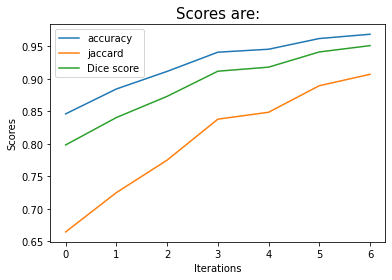

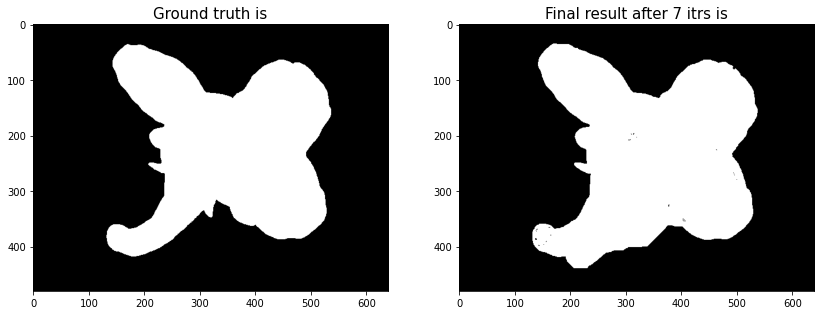

In [57]:
print(f"Total pipeline took {ans.time_track} secs for {len(ans.score_acc)} itrs (including costly overhead for storing state history for each iteration to make plots, user intervention etc)")
plot_all_details(ans)

A rectangle has been drawn
Size of the image is [h:480 ,w:640]
Bounding box coordinates:  {'w_min': 101, 'w_max': 543, 'h_min': 21, 'h_max': 437}
Graph constructed
Starting iteration: 0
Energy val:  3285741.646502319
Accuracy is  0.8490494791666666 | Jaccard is  0.6685559899649057
--------------------------


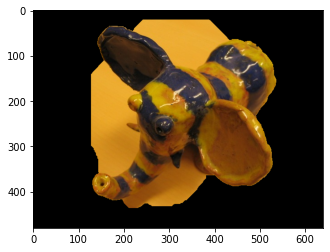

Starting iteration: 1
Energy val:  3227449.546825218
Accuracy is  0.8604915364583333 | Jaccard is  0.6857829947284685
--------------------------


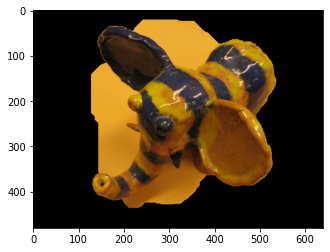

Starting iteration: 2
Energy val:  3223754.089068344
Accuracy is  0.8679557291666666 | Jaccard is  0.6975070656753593
--------------------------


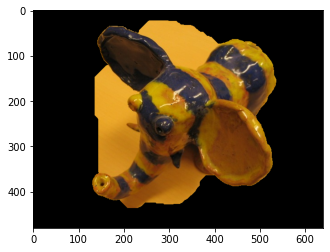

Starting iteration: 3
Energy val:  3233096.774491164
Accuracy is  0.93373046875 | Jaccard is  0.8212313069134783
--------------------------


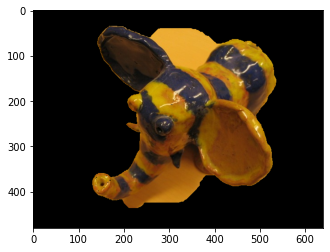

Starting iteration: 4
Energy val:  3184228.244907589
Accuracy is  0.9689388020833334 | Jaccard is  0.9073942875998409
--------------------------


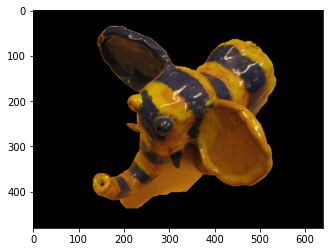

Starting iteration: 5
Energy val:  3166330.6637494164
Accuracy is  0.972158203125 | Jaccard is  0.916178286520708
--------------------------


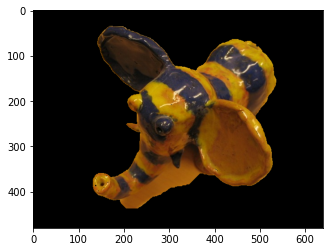

Starting iteration: 6
Energy val:  3167324.4840175626
Accuracy is  0.97236328125 | Jaccard is  0.9167353183476521
--------------------------


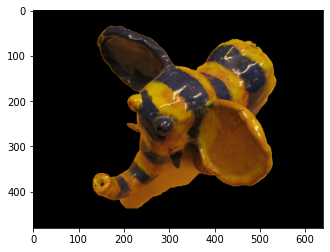

Starting iteration: 7
Energy val:  3166970.8784235413
Accuracy is  0.9724055989583333 | Jaccard is  0.9168513977439922
--------------------------


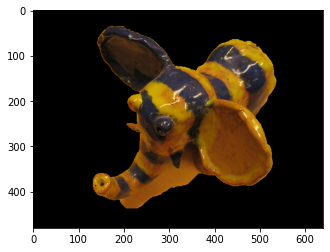

Starting iteration: 8
Energy val:  3167143.0470888168
Accuracy is  0.9723079427083333 | Jaccard is  0.9165595911841731
--------------------------


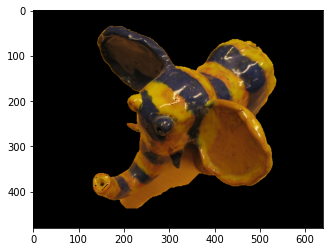

Starting iteration: 9
Energy val:  3166994.889469689
Accuracy is  0.9724055989583333 | Jaccard is  0.9168448725746012
--------------------------


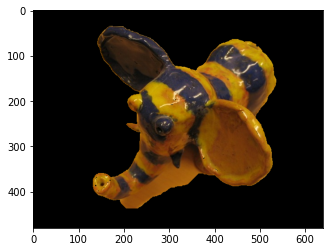

Starting iteration: 10
Energy val:  3166204.018278221
Accuracy is  0.9723958333333333 | Jaccard is  0.9168211556758772
--------------------------


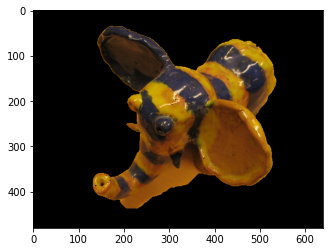

Starting iteration: 11
Energy val:  3166118.7493875837
Accuracy is  0.9725325520833333 | Jaccard is  0.9172071391426356
--------------------------


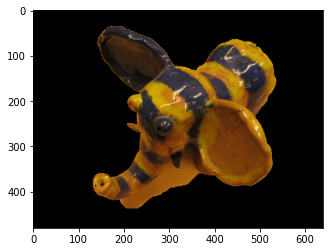

Initial pipeline over


KeyboardInterrupt: 

In [58]:
filename = '../images/ceramic.jpg'               # Path to image file
ans=run(filename,DEFAULT_ITRS=12,connectivity=8,input_num_gmms=10, input_gamma=50)
cv2.destroyAllWindows()

Total pipeline took 191.27507066726685 secs for 7 itrs (including costly overhead for storing state history for each iteration to make plots, user intervention etc)


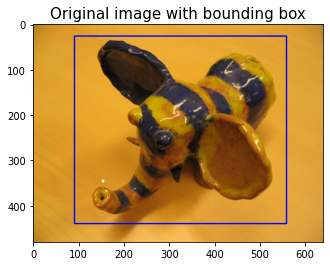

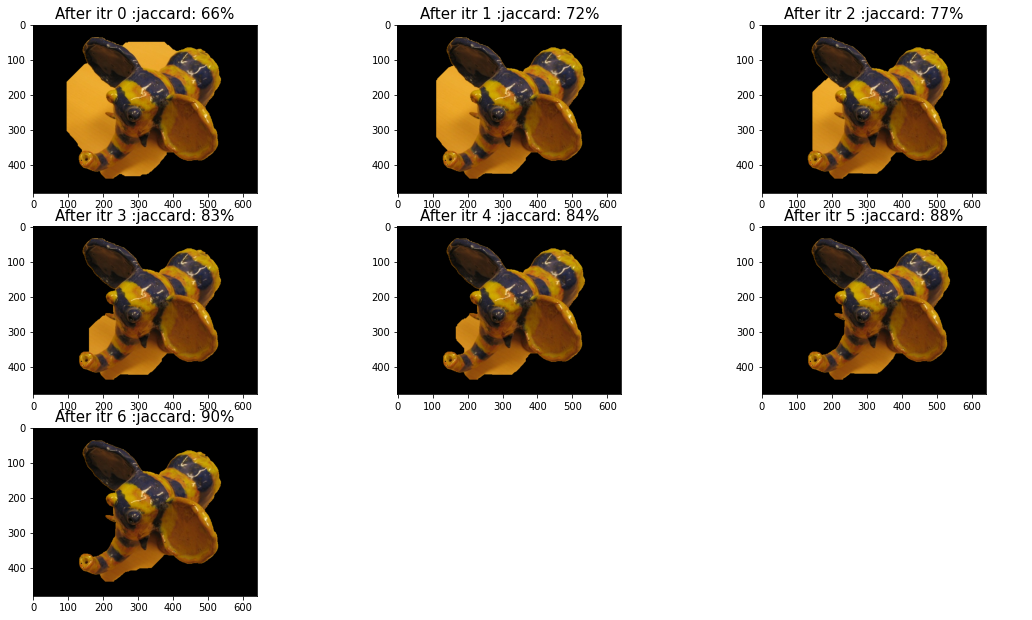

Accuracy:  [0.8463, 0.8846, 0.9117, 0.9412, 0.9458, 0.9623, 0.9689]
Jaccard:  [0.6645, 0.7251, 0.775, 0.8381, 0.8488, 0.8896, 0.9072]
Dice score is:  [0.7985, 0.8406, 0.8733, 0.9119, 0.9182, 0.9416, 0.9513]


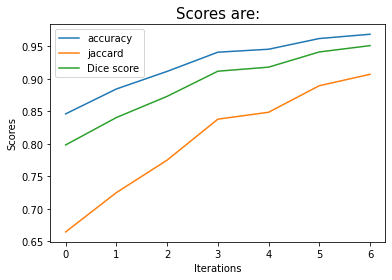

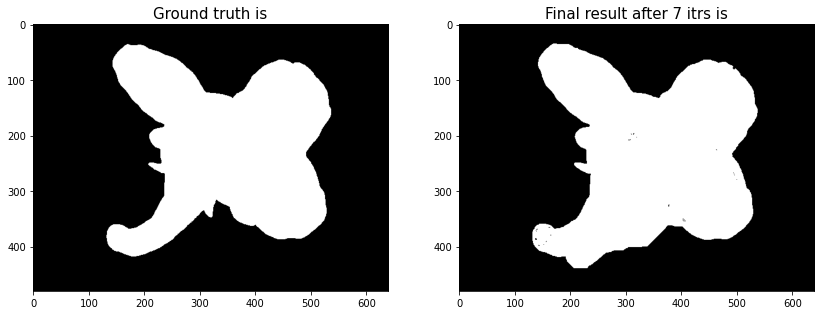

In [59]:
print(f"Total pipeline took {ans.time_track} secs for {len(ans.score_acc)} itrs (including costly overhead for storing state history for each iteration to make plots, user intervention etc)")
plot_all_details(ans)

A rectangle has been drawn
Size of the image is [h:480 ,w:640]
Bounding box coordinates:  {'w_min': 116, 'w_max': 541, 'h_min': 26, 'h_max': 420}
Graph constructed
Starting iteration: 0
Energy val:  3369334.3321172786
Accuracy is  0.9922102864583333 | Jaccard is  0.975020355331009
--------------------------


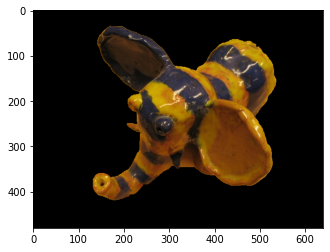

Starting iteration: 1
Energy val:  3244818.663260338
Accuracy is  0.9925260416666667 | Jaccard is  0.9760050999613322
--------------------------


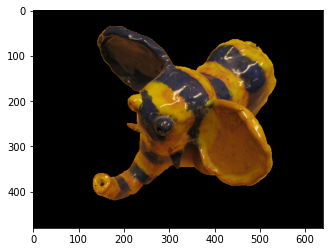

Initial pipeline over


In [72]:
filename = '../images/ceramic.jpg'               # Path to image file
ans=run(filename,DEFAULT_ITRS=2,connectivity=8,input_num_gmms=10, input_gamma=200)
cv2.destroyAllWindows()

## Effect of tighter VS loose bounding box

A rectangle has been drawn
Size of the image is [h:600 ,w:450]
Bounding box coordinates:  {'w_min': 35, 'w_max': 416, 'h_min': 29, 'h_max': 553}
Graph constructed
Starting iteration: 0
Energy val:  3074294.4575249017
Accuracy is  0.8064740740740741 | Jaccard is  0.3772480781836601
--------------------------


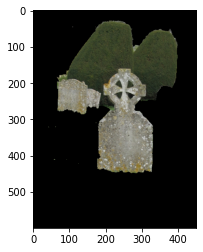

Starting iteration: 1
Energy val:  2997787.2910818877
Accuracy is  0.8009851851851851 | Jaccard is  0.36841486635793036
--------------------------


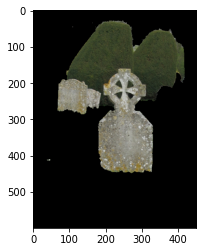

Starting iteration: 2
Energy val:  2986776.4715035446
Accuracy is  0.801074074074074 | Jaccard is  0.3696971119430134
--------------------------


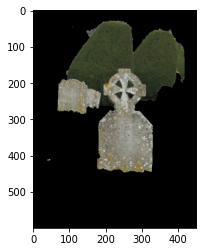

Starting iteration: 3
Energy val:  2997007.770190037
Accuracy is  0.8012074074074074 | Jaccard is  0.3697423733590099
--------------------------


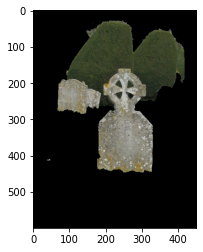

Initial pipeline over


KeyboardInterrupt: 

In [74]:
filename = '../images/grave.jpg'               # Path to image file
ans=run(filename,DEFAULT_ITRS=4,connectivity=8,input_num_gmms=5, input_gamma=50)
cv2.destroyAllWindows()

In [ ]:
print(f"Total pipeline took {ans.time_track} secs for {len(ans.score_acc)} itrs (including costly overhead for storing state history for each iteration to make plots, user intervention etc)")
plot_all_details(ans)

In [82]:
cv2.destroyAllWindows()

### Effect of 4 VS 8 connectivity

A rectangle has been drawn
Size of the image is [h:371 ,w:513]
Bounding box coordinates:  {'w_min': 73, 'w_max': 388, 'h_min': 91, 'h_max': 367}
Graph constructed
Starting iteration: 0
Energy val:  2268993.7284788997
Accuracy is  0.8689596107669594 | Jaccard is  0.5625098672092901
--------------------------


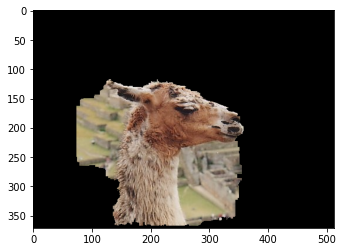

Starting iteration: 1
Energy val:  2245043.5449076965
Accuracy is  0.9758568328578259 | Jaccard is  0.8734055156073505
--------------------------


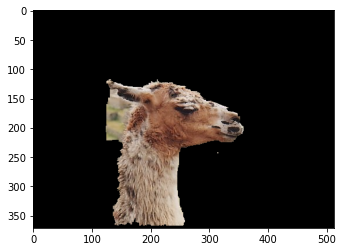

Starting iteration: 2
Energy val:  2228282.2968796445
Accuracy is  0.9877681625447265 | Jaccard is  0.9306792126969002
--------------------------


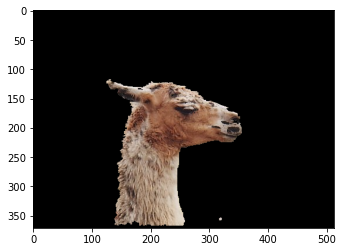

Starting iteration: 3
Energy val:  2228401.4355717204
Accuracy is  0.9875842646448406 | Jaccard is  0.9297123650316785
--------------------------


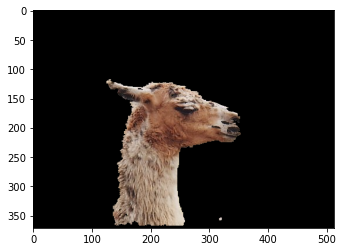

Starting iteration: 4
Energy val:  2223976.667147774
Accuracy is  0.9875579935162855 | Jaccard is  0.9295636396085547
--------------------------


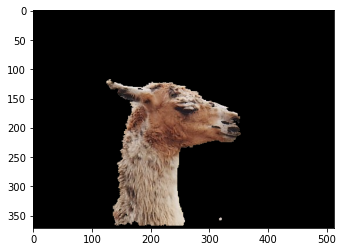

Initial pipeline over


In [83]:
filename = '../images/llama.jpg'               # Path to image file
ans=run(filename,DEFAULT_ITRS=5,connectivity=4,input_num_gmms=5, input_gamma=50)
cv2.destroyAllWindows()